In [1]:
import scanpy as sc
import sys
sys.path.append(r"D:\Scunpair_Project\Diagonal-integration")
adata_RNA = sc.read_h5ad(r'..\data\tea-seq\RNA.h5ad')
adata_ADT = sc.read_h5ad(r'..\data\tea-seq\ADT.h5ad')


In [2]:
import anndata as ad
import numpy as np 
import pandas as pd
adata_ADT.obs['celltype'] = adata_RNA.obs['celltype']
correspondence = pd.read_csv(r'..\data\tea-seq\protein_gene_conversion.csv')
correspondence['Protein name'] = correspondence['Protein name'].replace(to_replace={'TCRab': 'TCR-a/b', 'TCRgd': 'TCR-g/d'})
print(correspondence)

rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in adata_ADT.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in adata_RNA.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])

rna_protein_correspondence = np.array(rna_protein_correspondence)
RNA_shared = adata_RNA[:, rna_protein_correspondence[:, 0]].copy()
ADT_shared = adata_ADT[:, rna_protein_correspondence[:, 1]].copy()
RNA_shared.var['feature_name'] = RNA_shared.var.index.values
ADT_shared.var['feature_name'] = ADT_shared.var.index.values
RNA_shared.var_names_make_unique()
ADT_shared.var_names_make_unique()

RNA_unshared = adata_RNA[:, sorted(set(adata_RNA.var.index) - set(rna_protein_correspondence[:, 0]))].copy()
ADT_unshared = adata_ADT[:, sorted(set(adata_ADT.var.index) - set(rna_protein_correspondence[:, 1]))].copy()

sc.pp.highly_variable_genes(RNA_unshared, flavor='seurat_v3', n_top_genes=1000)
RNA_unshared = RNA_unshared[:, RNA_unshared.var.highly_variable].copy()

RNA_unshared.var['feature_name'] = RNA_unshared.var.index.values
ADT_unshared.var['feature_name'] = ADT_unshared.var.index.values
RNA_counts = RNA_shared.X.sum(axis=1)
ADT_counts = ADT_shared.X.sum(axis=1)
target_sum = np.maximum(np.median(np.array(RNA_counts).copy()), 20)

sc.pp.normalize_total(RNA_shared, target_sum=target_sum)
sc.pp.log1p(RNA_shared)
sc.pp.scale(RNA_shared, max_value=10)

sc.pp.normalize_total(ADT_shared, target_sum=target_sum)
sc.pp.log1p(ADT_shared)
sc.pp.scale(ADT_shared, max_value=10)

sc.pp.normalize_total(RNA_unshared)
sc.pp.log1p(RNA_unshared)
sc.pp.scale(RNA_unshared, max_value=10)

sc.pp.normalize_total(ADT_unshared)
sc.pp.log1p(ADT_unshared)
sc.pp.scale(ADT_unshared, max_value=10)

adata1 = ad.concat([ADT_shared, ADT_unshared], axis=1)
adata2 = ad.concat([RNA_shared, RNA_unshared], axis=1)

adata1.obs = adata_ADT.obs
adata2.obs = adata_RNA.obs

adata1.obsm['link_feat'] = ADT_shared.X
adata2.obsm['link_feat'] = RNA_shared.X


      Protein name                   RNA name
0             CD80                       CD80
1             CD86                       CD86
2            CD274                      CD274
3            CD273                   PDCD1LG2
4            CD275                     ICOSLG
..             ...                        ...
336         HLA.DR  HLA-DRA/HLA-DRB1/HLA-DRB3
337  TCR.Va24.Ja18       Ignore: isoform skip
338      TCR.Va7.2       Ignore: isoform skip
339        TCR.a.b                    TRA/TRB
340        TCR.g.d                    TRG/TRD

[341 rows x 2 columns]


c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\legacy_api_wrap\__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
c:\Users\Administrator\miniconda3\envs\mycode\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
c:\Users\Administrator\miniconda3\envs\mycode\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [3]:
import mycode
mycode.smooth_link_feat(adata1, adata2, n_neighbors=15, metric='correlation', weight=0.3)

c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
model = mycode.Model(adata1, adata2, batch_size=500, 
                           training_steps=5001, seed=1234, celltype_col='celltype',
                            n_latent=16, lambdaRecon = 10.0, lambdaLA = 10.0, 
                            lambdaAlign = 1.0, lambdaGeo=0.5, lambdamGAN = 1.0, lambdabGAN = 1.0, n_KNN = 30, mode = 'weak', use_prior = False)

In [11]:
model.train()
model.eval()

Training started at: Sun Sep 28 10:04:48 2025
Step 0 | loss_Recon: 19.0084 | loss_LA: 43.9838 | loss_Align: 2.3358 | loss_Geo: 1.3642 | loss_mGAN vs loss_mDis: -1.2172 vs 1.2546 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 1000 | loss_Recon: 8.1448 | loss_LA: 0.0840 | loss_Align: 0.0900 | loss_Geo: 0.0552 | loss_mGAN vs loss_mDis: -1.3556 vs 1.3625 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 2000 | loss_Recon: 7.7059 | loss_LA: 0.0617 | loss_Align: 0.0686 | loss_Geo: 0.0428 | loss_mGAN vs loss_mDis: -1.3220 vs 1.3303 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 3000 | loss_Recon: 7.4888 | loss_LA: 0.0540 | loss_Align: 0.0592 | loss_Geo: 0.0355 | loss_mGAN vs loss_mDis: -1.2984 vs 1.3100 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 4000 | loss_Recon: 7.6092 | loss_LA: 0.0632 | loss_Align: 0.0588 | loss_Geo: 0.0352 | loss_mGAN vs loss_mDis: -1.2654 vs 1.2869 | loss_bGAN vs loss_bDis: -0.0000 vs 0.0000
Step 5000 | loss_Recon: 7.6232 | loss_LA: 0.0631 | loss_Align: 0.0595 

In [12]:
X = model.latent
y = np.concatenate([adata1.obsm['X_pca'], adata2.obsm['X_pca']], axis=0)
ct = pd.concat([adata_ADT.obs['celltype'], adata_RNA.obs['celltype']]).to_numpy()
batch = np.array(['ADT'] * adata_ADT.shape[0] + ['RNA'] * adata_RNA.shape[0])
map_score = mycode.metrics.mean_average_precision(X, ct, neighbor_frac=0.1)
asw_celltype = mycode.metrics.avg_silhouette_width(X, ct)
NC = mycode.metrics.neighbor_conservation(X, y, batch)
#nmi = mycode.metrics.normalized_mutual_info(X, ct)
asw_batch = mycode.metrics.avg_silhouette_width_batch(X, batch, ct)
sas = mycode.metrics.seurat_alignment_score(X, batch)
GC = mycode.metrics.graph_connectivity(X, batch)
foscttm = mycode.metrics.foscttm(X[:adata_ADT.shape[0], :], X[adata_ADT.shape[0]:, :])

print("Mean Average Precision (MAP):", map_score)
print("ASW_celltype:", asw_celltype)
print("neighbor conservation:", NC)
#print("NMI:", nmi)
print("ASW_batch:", asw_batch)
print("Seurat Alignment Score:", sas)
print("Graph connectivity:", GC)
print("FOSCTTM:", foscttm)

c:\Users\Administrator\miniconda3\envs\mycode\lib\site-packages\anndata\_core\anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
D:\Scunpair_Project\Diagonal-integration\mycode\metrics.py:326: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = pd.value_counts(c)


Mean Average Precision (MAP): 0.8089958773950606
ASW_celltype: 0.5743679851293564
neighbor conservation: 0.32819938508436297
ASW_batch: 0.9609962105751038
Seurat Alignment Score: 0.9139943309030758
Graph connectivity: 0.99986553717897
FOSCTTM: 0.14015244073705296


In [13]:
adata_integrated = ad.AnnData(X=model.latent)
adata_integrated.obs = pd.concat([adata_ADT.obs, adata_RNA.obs])
adata_integrated.obs['modality'] = ['ADT'] * adata1.shape[0] + ['RNA'] * adata2.shape[0]

In [14]:
sc.pp.neighbors(adata_integrated)
sc.tl.umap(adata_integrated, min_dist=0.3)

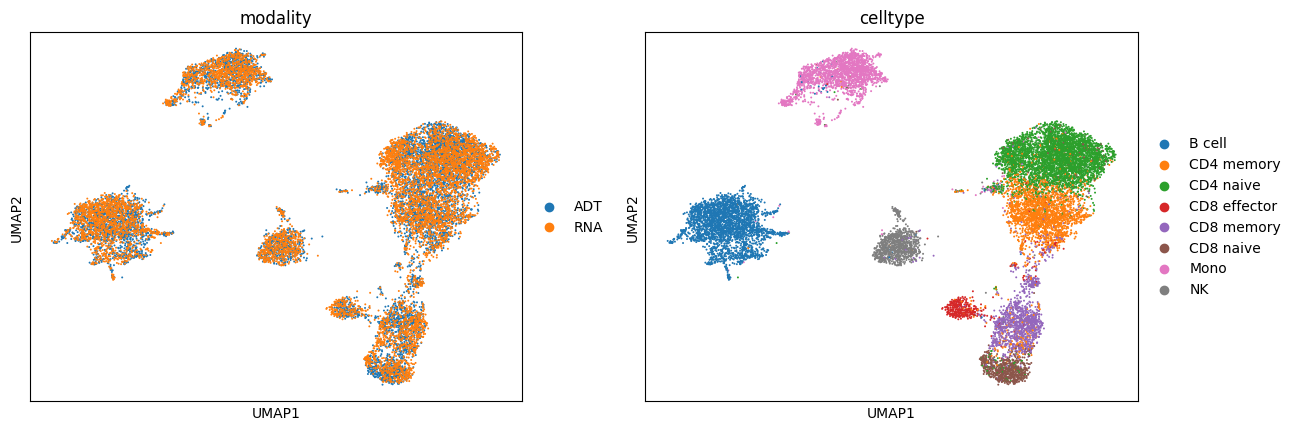

In [15]:
sc.pl.umap(adata_integrated, color=['modality','celltype'])